In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import rcParams
import warnings
warnings.filterwarnings('ignore')

import re
import jax.numpy as jnp
from jax import grad, jit, partial
import jax
import ticktack
from ticktack import fitting
from tqdm import tqdm

import blackjax.hmc as hmc
import blackjax.nuts as nuts
import blackjax.stan_warmup as stan_warmup
import jax.scipy.stats as stats
import blackjax.nuts as nuts
import corner
rcParams['figure.figsize'] = (10.0, 5.0)

In [2]:
cbm = ticktack.load_presaved_model('Guttler14', production_rate_units = 'atoms/cm^2/s')
cf = fitting.CarbonFitter(cbm)
cf.load_data('400_BCE_Data_processed.csv', time_oversample=50)
cf.prepare_function(use_control_points=True, gap_years=3, dense_years=2)

In [3]:
params = jnp.array([1.89363959, 1.77072593, 1.75264088, 1.56139717, 1.91315407,
       2.18186108, 2.12273598, 2.15139975, 1.8747374 , 1.9919975 ,
       2.26624611, 2.32133033, 2.21331508, 2.00514102, 1.95528112,
       2.08758559, 2.40094881, 2.2423129 , 2.35118368, 2.01433349,
       2.17496925, 2.39776699, 1.84525825, 2.23184444, 2.06272956,
       2.06850577, 2.00214273, 1.77290152])

In [4]:
cf.control_points_time

DeviceArray([-427., -426., -422., -418., -414., -411., -408., -405.,
             -402., -399., -396., -393., -390., -386., -382., -375.,
             -371., -367., -363., -359., -355., -351., -347., -343.,
             -339., -335., -331., -327.], dtype=float64)

In [5]:
cf.end

-325

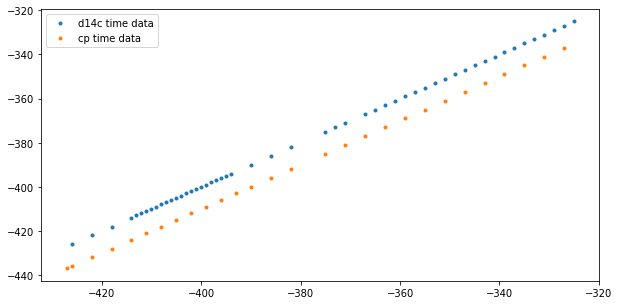

In [6]:
plt.plot(cf.time_data, cf.time_data, ".", label="d14c time data")
plt.plot(cf.control_points_time, cf.control_points_time -10, ".", label="cp time data")
plt.legend()

In [7]:
sampler = cf.sampling(params, burnin=1000, production=2000, log_like=False)

Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:43<00:00,  2.16it/s]


Running production...


100%|███████████████████████████████████████████████████████████████████████████████| 2000/2000 [15:34<00:00,  2.14it/s]


In [8]:
mean = np.mean(sampler.flatchain, axis=0)

In [9]:
mean

array([1.87079647, 2.4923226 , 1.73753268, 1.40543558, 2.14220931,
       2.32770132, 1.85984496, 2.47951715, 1.70023599, 2.12736712,
       2.19885596, 2.33819053, 2.42105666, 1.71490296, 2.36417482,
       1.74934708, 3.01016245, 1.63945769, 2.74362446, 1.8492909 ,
       2.05282665, 2.77250899, 1.37455821, 2.69524713, 1.8188731 ,
       2.16052228, 2.16980929, 1.47755782])

In [10]:
std = np.std(sampler.flatchain, axis=0)

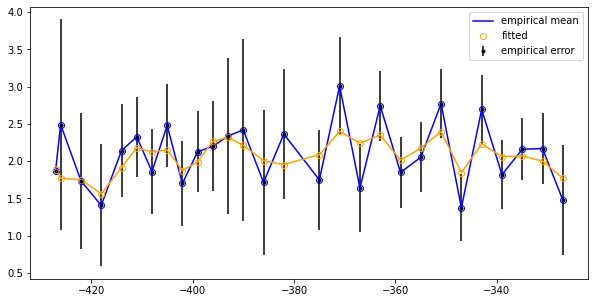

In [11]:
d14c = cf.dc14(params=mean)
d14c_fine = cf.dc14_fine(params=mean)
plt.errorbar(cf.control_points_time, mean, yerr=std, fmt=".k", label="empirical error")
plt.plot(cf.control_points_time, mean, "bo", fillstyle="none")
plt.plot(cf.control_points_time, mean, color="b", label="empirical mean")
plt.plot(cf.control_points_time, params, 'o', color="orange", fillstyle="none", label="fitted")
plt.plot(cf.control_points_time, params, color="orange")
plt.legend()

In [12]:
cf.log_like(params=mean)

DeviceArray(-6.1511419, dtype=float64)

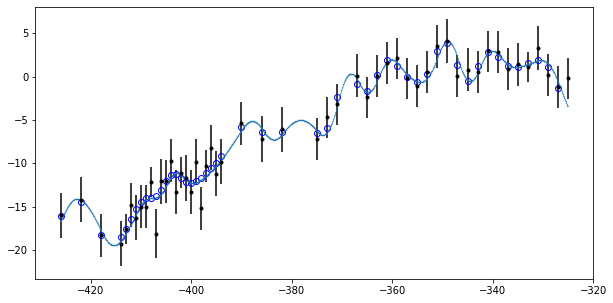

In [13]:
plt.plot(cf.time_data[:-1], d14c, "ob", fillstyle="none")
plt.errorbar(cf.time_data, cf.d14c_data, yerr=cf.d14c_data_error, fmt=".k", label="true")
plt.plot(cf.time_grid_fine, d14c_fine, ".", markersize=0.5)

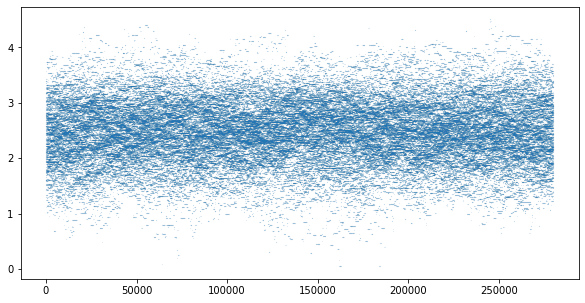

In [14]:
plt.plot(sampler.flatchain[:, 7], ".", markersize=0.09)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 107.31it/s]


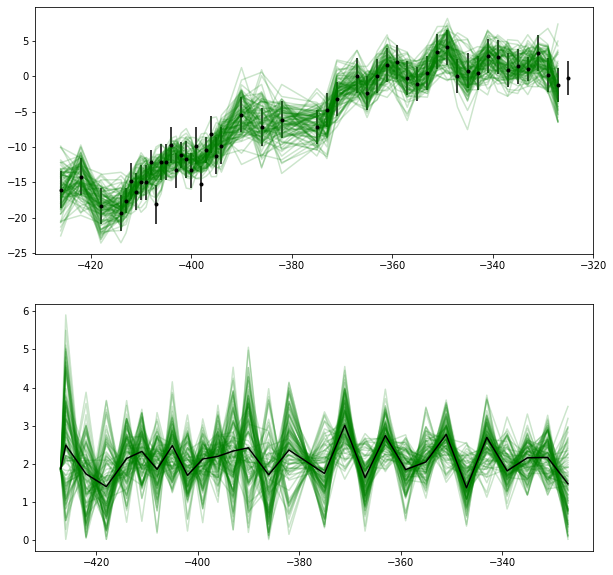

In [15]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))
n = 100
top_n = np.random.permutation(len(sampler.flatchain))[:n]
ax1.errorbar(cf.time_data, cf.d14c_data, yerr=cf.d14c_data_error, fmt=".k", label="true")
for i in tqdm(top_n):
    d14c = cf.dc14(params=sampler.flatchain[i, :])
    ax1.plot(cf.time_data[:-1], d14c, color="g", alpha=0.2)
    ax2.plot(cf.control_points_time, sampler.flatchain[i, :], color="g", alpha=0.2)
ax2.plot(cf.control_points_time, mean, "k")

In [16]:
sample = sampler.flatchain[4000:, 10:17]

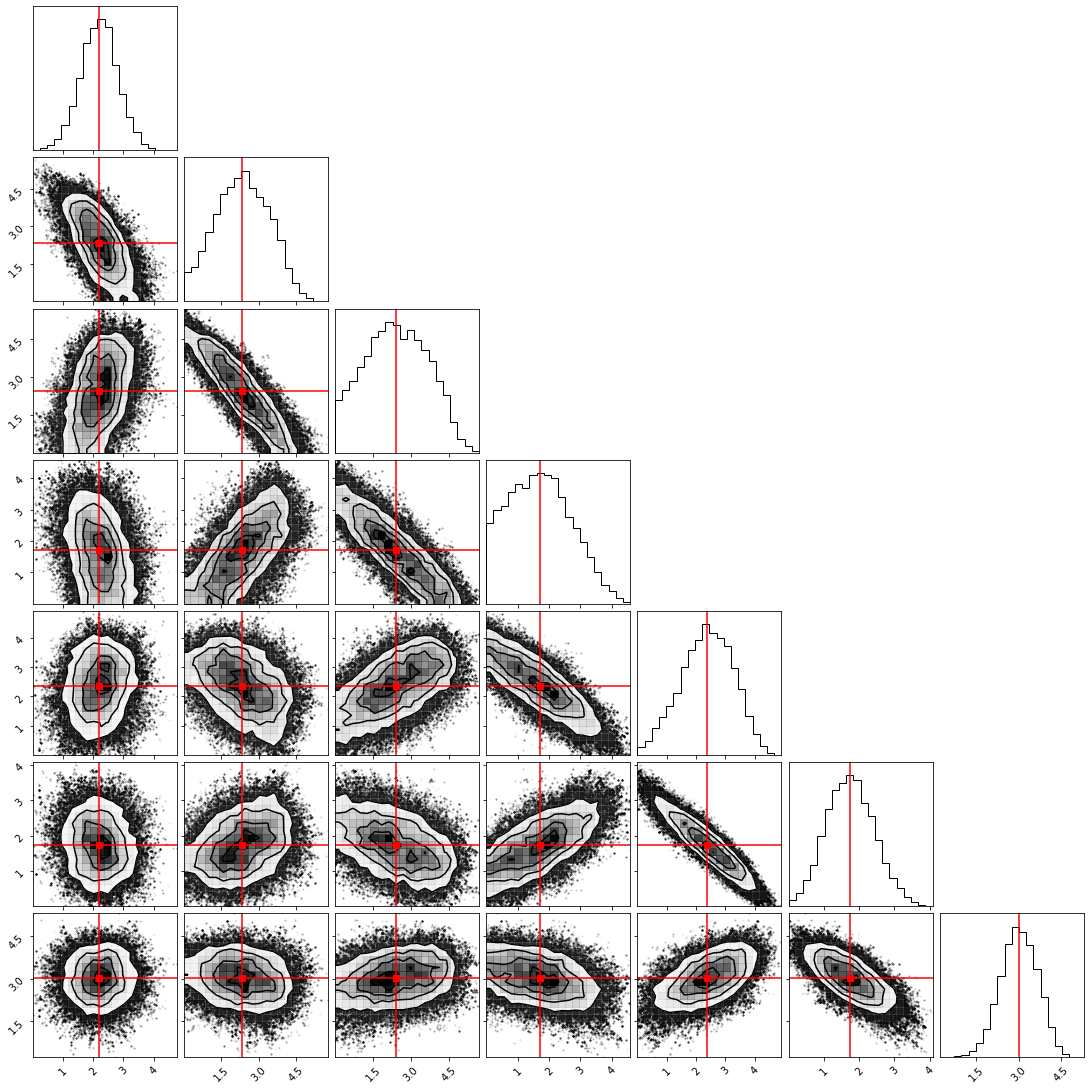

In [17]:
ndim = sample.shape[1]
figure = corner.corner(sample)
value = np.mean(sample, axis=0)
axes = np.array(figure.axes).reshape((ndim, ndim))
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(value[i], color="r")

for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value[xi], color="r")
        ax.axhline(value[yi], color="r")
        ax.plot(value[xi], value[yi], "sr")